<a href="https://colab.research.google.com/github/lsaif/FractureDetection/blob/master/FractureDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Authenticate to access Google Drive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

###Import supporting libraries

In [313]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, label_binarize
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import timeit

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


###Data Loading

In [0]:
def LoadData(url,filename):
  fluff, id = url.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)
  return filename

LoadData(url="https://drive.google.com/open?id=1qnGa_lKiTHcmclC-__yLMV8QYksMFeLO", filename="fractureintensitydata.csv")
dset = pd.read_csv("fractureintensitydata.csv").set_index('WELL')
print(dset.head(5))
dset = dset.dropna()

###Data Preprocessing

####Calculation

In [0]:
dset['RES']=dset.ILD / dset.PROX
dset['DRHOB']=dset.RHOB - dset.RHO_COR
dset['FRAC']=dset['INTENSITY'].apply(lambda x: (1 if x >0 else 0))

####Visualization

In [0]:
sns.set()
sns.pairplot(dset)

corr = dset.corr()
sns.heatmap(corr, cmap = 'YlGn', xticklabels=corr.columns,yticklabels=corr.columns, annot=True, linewidth = 5) 

#sns.pairplot(dset[["GR", "RHOB", "RHO_COR", "ILD", "PROX", "SPI", "DT", "CALI", "INTENSITY"]], diag_kind="kde")

####Preprocessing

In [0]:
dataset = dset[['DEPTH','GR','RES','DRHOB','RHOB','CALI','SPI','DT','INTENSITY','FRAC']].copy()
db = dataset[dataset.index == 'JTB-118']
#db = pd.concat([db,dataset[dataset.index == 'JTB-120']],sort=False)
X = db.iloc[:,1:8].values
Y = db.iloc[:,-1].values.reshape(-1,1)
#Y = label_binarize(Y, classes=[0,1])

test = 0.20
seed = 0
batch = 1500
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X, Y, test_size=test, random_state=seed)

#scaler = MinMaxScaler()
#Y_train = scaler.fit_transform(Y_train)
#Y_val = scaler.transform(Y_val)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

X_train = torch.from_numpy(X_train).float().to(device)
Y_train = torch.from_numpy(Y_train).to(device)
X_val = torch.from_numpy(X_val).float().to(device)
Y_val = torch.from_numpy(Y_val).to(device)

trainset = TensorDataset(X_train, Y_train)
trainloader = DataLoader(trainset, batch_size=batch, shuffle=True)

valset = TensorDataset(X_val, Y_val)
valloader = DataLoader(valset, batch_size=batch, shuffle=True)

print (Y_train)

###Model

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(7, 4)
        self.output = nn.Linear(4, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        x = self.logsoftmax(x)
        
        return x

###Train, test, predict

In [0]:
model = Network()
model.cuda()
Xtrain, Ytrain = next(iter(trainloader))
Xval, Yval = next(iter(valloader))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr= 0.001)
epoch = 200
loss_ = []
loss_test = []
for i in range(epoch):
    running_loss = 0
    runningloss_test = 0
    for Xtrain, Ytrain in trainloader:
        Ytrain = Ytrain.view(-1)
        optimizer.zero_grad()
        out = model(Xtrain)
        print(out.shape)
        print(Ytrain.shape)
        loss = criterion(out,Ytrain)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        Yval = Yval.view(-1)
        with torch.no_grad():
          logps = model(Xval)
        predict = torch.exp(logps).argmax(1)
        runningloss_test = criterion(logps,Yval).cpu().numpy()
        #loss_test += runningloss_test.item()
        print(f"Training loss: {running_loss/len(trainloader)}")
        print(f"Val loss: {runningloss_test/len(valloader)}")
        loss_test.append(runningloss_test/len(valloader))
        loss_.append(running_loss/len(trainloader))

###History

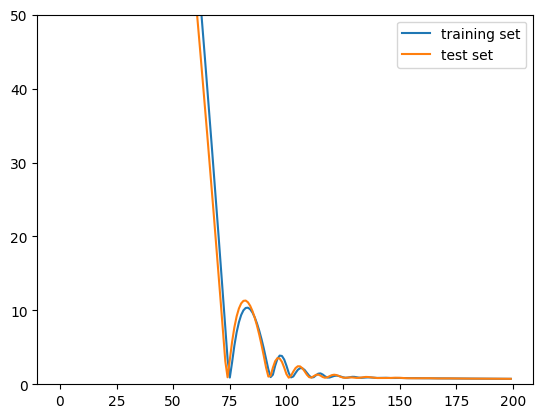

In [454]:
plt.plot(range(epoch),loss_,label="training set")
plt.plot(range(epoch),loss_test,label="test set")
plt.ylim([0,50])
plt.legend()

###Blind test

In [0]:
threshold = 0.8

testset = dataset[dset.index == 'JTB-121'].dropna()
X_test = torch.Tensor(testset.iloc[:,1:8].values)
Y_test = torch.Tensor(testset.iloc[:,-1].values)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
with torch.no_grad():
      logps = model(X_test)
predict = torch.exp(logps).cpu()
Y_predict = (predict[:,0] >= threshold).numpy().astype(int)
#Y_predict = predict.argmax(1)
#print(predict)
testset['FRAC_PREDICT']=predict[:,1]

####Visualize result

In [0]:
d = testset['DEPTH']
plt.style.use('default')

fig = plt.gcf()
fig.set_size_inches(3, 6)
fig.gca().invert_yaxis()
plt.tick_params(labelsize=10)
plt.xlim([-0.1,3])
plt.xlabel('Fracture probability',{'fontsize': 10, 'fontweight' : 5})
plt.ylabel('Depth (m)',{'fontsize': 10, 'fontweight' : 5})
plt.title(testset.index.any(),{'fontsize': 15, 'fontweight' : 5})
#plt.scatter(testset['FRAC'],d,color='r',label='Actual')
plt.plot(testset['FRAC_PREDICT'],d,label='Proba')
#plt.plot(testset['SPI']+0.5,d,label='SPI')
#plt.plot(testset['INTENSITY']/10,d,label='Intensity')
plt.legend()

####Accuracy

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
Y_test = Y_test.cpu()
mse_val = mean_squared_error(predict[:,1],Y_test)
mae_val = mean_absolute_error(predict[:,1],Y_test)
variance_val = explained_variance_score(predict[:,1],Y_test)
r2_val = r2_score(predict[:,1],Y_test)
acc_val = accuracy_score(Y_predict,Y_test)
cm = confusion_matrix(Y_test, Y_predict)
print('mse= ',mse_val,'\nmae= ',mae_val,'\nvar= ',variance_val,'\nr2= ',r2_val,'\nacc= ',acc_val)
print(cm)

### Save model

In [0]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

from google.colab import drive
drive.mount('/content/gdrive')
model_save_name = 'model2604.pt'
path = F"/content/gdrive/My Drive/FracDet/{model_save_name}" 
torch.save(model.state_dict(), path)